<a href="https://colab.research.google.com/github/Anshul-Kum/DAT490/blob/main/DAT490_Capstone_Zero_Shot_(BART_Large_MNLI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Methodology

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import storage

project_id = "sharp-matter-449521-u2"
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
!wget -P /usr/lib/spark/jars/ https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar

--2025-04-09 22:20:49--  https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 142.250.99.207, 142.250.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40713341 (39M) [application/java-archive]
Saving to: ‘/usr/lib/spark/jars/gcs-connector-hadoop3-latest.jar’

gcs-connector-hadoo 100%[===================>]  38.83M   207MB/s    in 0.2s    

2025-04-09 22:20:49 (207 MB/s) - ‘/usr/lib/spark/jars/gcs-connector-hadoop3-latest.jar’ saved [40713341/40713341]



In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder \
    .appName("BigDataProcessing") \
    .config("spark.jars", "/usr/lib/spark/jars/gcs-connector-hadoop3-latest.jar") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.fs.gs.auth.service.account.enable", "true") \
    .getOrCreate()

In [ ]:
spark

In [ ]:
df_reviews = spark.read.parquet('gs://final_dataset_dat490/dat490_final_dataset_cleaned.parquet', headers=True, inferSchema=True)

In [ ]:
df_reviews.columns

['gmap_id',
 'customer_name',
 'rating',
 'reviews',
 'time',
 'avg_rating',
 'category',
 'latitude',
 'longitude',
 'business_name',
 'num_of_reviews',
 'state',
 'standard_category',
 'Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday',
 'timestamp',
 'week',
 'month',
 'year',
 'time_seconds']

## VADER

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download("vader_lexicon")

# Initializing VADER
sia = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    if text:
        return float(sia.polarity_scores(text)["compound"])
    else:
        return 0.0

vader_udf = udf(vader_sentiment, FloatType())

df_sentiment = df_reviews.withColumn("sentiment_score", vader_udf("reviews"))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
from pyspark.sql.functions import when

df_sentiment = df_sentiment.withColumn(
    "sentiment_label",
    when(df_sentiment["sentiment_score"] > 0.2, "Positive")
    .when(df_sentiment["sentiment_score"] < -0.2, "Negative")
    .otherwise("Neutral")
)

In [ ]:
from pyspark.sql.functions import approx_count_distinct

df_sentiment.groupBy("sentiment_label").agg(approx_count_distinct("gmap_id").alias("approx_count")).show()

+---------------+------------+
|sentiment_label|approx_count|
+---------------+------------+
|       Positive|     2598785|
|        Neutral|      149531|
|       Negative|      197929|
+---------------+------------+



In [ ]:
from pyspark.sql.functions import when

df_sentiment = df_sentiment.withColumn(
    "sentiment_label",
    when(df_sentiment["sentiment_score"] > 0.05, "Positive")
    .when(df_sentiment["sentiment_score"] < -0.05, "Negative")
    .otherwise("Neutral")
)

In [ ]:
df_sentiment.select("reviews", "sentiment_score", "sentiment_label").show(10)

+--------------------+---------------+---------------+
|             reviews|sentiment_score|sentiment_label|
+--------------------+---------------+---------------+
|The pizza, steak ...|         0.6114|       Positive|
|Great way to get ...|         0.6249|       Positive|
|Went there for a ...|         0.7392|       Positive|
|Friendly and know...|         0.4939|       Positive|
|My personal choic...|         0.8308|       Positive|
|This store has be...|        -0.6324|       Negative|
|I am disappointed...|          0.975|       Positive|
|AUAF oversee a va...|         0.9042|       Positive|
|Great neighborhoo...|         0.6249|       Positive|
|This is place is ...|         0.8807|       Positive|
+--------------------+---------------+---------------+
only showing top 10 rows



In [ ]:
from pyspark.sql.functions import approx_count_distinct

df_sentiment_counts = df_sentiment.groupBy("sentiment_label").agg(approx_count_distinct("gmap_id").alias("approx_count"))

In [ ]:
from pyspark.sql.functions import approx_count_distinct

df_sentiment.groupBy("sentiment_label").agg(approx_count_distinct("gmap_id").alias("approx_count")).show()

+---------------+------------+
|sentiment_label|approx_count|
+---------------+------------+
|       Positive|     2647752|
|        Neutral|       91804|
|       Negative|      227790|
+---------------+------------+



In [ ]:
from pyspark.sql.functions import col, round

df_percentages = df_sentiment_counts.withColumn(
    "percentage", round((col("approx_count") / 2884722) * 100, 2)
)

## TextBlob

In [ ]:
from pyspark.sql.functions import col, when, regexp_replace
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, DoubleType, StringType

def get_textblob_sentiment(text):
    if text is not None and isinstance(text, str):
        blob = TextBlob(text)
        return float(blob.sentiment.polarity), float(blob.sentiment.subjectivity)
    else:
        return 0.0, 0.0

schema = StructType([
    StructField("polarity", DoubleType(), True),
    StructField("subjectivity", DoubleType(), True)
])

sentiment_udf = udf(get_textblob_sentiment, schema)

df_reviews = df_reviews.withColumn("sentiment", sentiment_udf("reviews"))
df_reviews = df_reviews.withColumn("polarity", col("sentiment.polarity"))
df_reviews = df_reviews.withColumn("subjectivity", col("sentiment.subjectivity"))

In [ ]:
from pyspark.sql.functions import when

# Putting all the reviews into 3 categories based on their polarity
df_reviews = df_reviews.withColumn(
    "sentiment_label",
    when(col("polarity") <= -0.2, "Negative").
    when(col("polarity") <= 0.2, "Neutral").
    otherwise("Positive")
)

In [ ]:
df_reviews.select('reviews', 'polarity', 'sentiment_label').show(10, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+---------------+
|reviews                                                                                                                                                                                                                

In [ ]:
sentiment_label_count = df_reviews.groupby('sentiment_label').count()

In [ ]:
from pyspark.sql.functions import col, round
df_sentiment_all = df_reviews.withColumn("sentiment_score", vader_udf("reviews"))
df_sentiment_all = df_sentiment_all.withColumn("polarity", col("sentiment.polarity"))
df_sentiment_all.columns

['gmap_id',
 'customer_name',
 'rating',
 'reviews',
 'time',
 'avg_rating',
 'category',
 'latitude',
 'longitude',
 'business_name',
 'num_of_reviews',
 'state',
 'standard_category',
 'Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday',
 'timestamp',
 'week',
 'month',
 'year',
 'time_seconds',
 'sentiment',
 'polarity',
 'subjectivity',
 'sentiment_label',
 'sentiment_score']

In [ ]:
from pyspark.sql.functions import when, length, col
from pyspark.sql import functions as F

df_labeled = df_sentiment_all.withColumn(
    "vader_label",
    when(col("sentiment_score") >= 0.05, "Positive")
    .when(col("sentiment_score") <= -0.05, "Negative")
    .otherwise("Neutral")
)
df_labeled = df_labeled.withColumn(
    "textblob_label",
    when(col("polarity") >= 0.05, "Positive")
    .when(col("polarity") <= -0.05, "Negative")
    .otherwise("Neutral")
)
df_labeled = df_labeled.withColumn("review_length", length(col("reviews")))

df_labeled = df_labeled.withColumn(
    "length_bucket",
    when(col("review_length") < 100, "Short")
    .when(col("review_length") <= 300, "Medium")
    .otherwise("Long")
)

top_categories = [row['standard_category'] for row in df_labeled.groupBy("standard_category")
                  .count().orderBy(F.desc("count")).limit(5).collect()]

df_filtered = df_labeled.filter(col("standard_category").isin(top_categories))

samples = []
for category in top_categories:
    for label in ["Positive", "Negative", "Neutral"]:
        for length_group in ["Short", "Medium", "Long"]:
            subset = (
                df_filtered.filter(
                    (col("standard_category") == category) &
                    (col("vader_label") == label) &
                    (col("length_bucket") == length_group)
                ).orderBy(F.rand()).limit(1)
            )
            samples.append(subset)

df_sample_30 = samples[0]
for i in range(1, len(samples)):
    df_sample_30 = df_sample_30.union(samples[i])

df_final = df_sample_30.select(
    "reviews", "standard_category", "review_length",
    "vader_label", "sentiment", "textblob_label", "polarity"
)

df_final.show(30, truncate=False)


In [ ]:
df_final_30 = df_final.limit(30)

In [ ]:
from transformers import pipeline

# Load zero-shot classification model
zero_shot_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [ ]:
from pyspark.sql.functions import when, length, col

df_bucketed = df_reviews.withColumn("review_length", length(col("reviews")))

df_bucketed = df_bucketed.withColumn(
    "length_bucket",
    when(col("review_length") < 100, "Short")
    .when(col("review_length") <= 300, "Medium")
    .otherwise("Long")
)

In [ ]:
from pyspark.sql import functions as F

# Group count
group_counts = df_bucketed.groupBy("standard_category", "length_bucket").count()

# Total rows
total_count = df_bucketed.count()

# Target sample size
sample_target = 10000

# Compute fraction per group
group_fractions = group_counts.withColumn(
    "fraction", (F.col("count") / total_count) * sample_target
).withColumn(
    "sample_size", F.round("fraction").cast("int")
)


In [ ]:
sampled_dfs = []

for row in group_fractions.collect():
    cat = row['standard_category']
    bucket = row['length_bucket']
    n = row['sample_size']

    if n > 0:
        subset = (
            df_bucketed.filter(
                (col("standard_category") == cat) &
                (col("length_bucket") == bucket)
            )
            .orderBy(F.rand())
            .limit(n)
        )
        sampled_dfs.append(subset)


In [ ]:
df_sample_10k = sampled_dfs[0]
for sdf in sampled_dfs[1:]:
    df_sample_10k = df_sample_10k.union(sdf)


In [ ]:
output_path = "gs://final_dataset_dat490/sample_reviews_stratified_10k.parquet"

In [ ]:
df_sample_10k.write.mode("overwrite").parquet(output_path)

In [ ]:
import pandas as pd
df_sample_pandas = pd.read_parquet(output_path)
df_sample_pandas = df_sample_pandas.sort_values(["gmap_id", "timestamp"]).reset_index(drop=True)
df_sample_pandas.columns

Index(['gmap_id', 'customer_name', 'rating', 'reviews', 'time', 'avg_rating',
       'category', 'latitude', 'longitude', 'business_name', 'num_of_reviews',
       'state', 'standard_category', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'timestamp', 'week',
       'month', 'year', 'time_seconds', 'review_length', 'length_bucket'],
      dtype='object')

In [ ]:
df_sample_pandas[['reviews']]

,reviews
0,Nice clean place and very friendly staff. Only...
1,This company helped us buy our land 15 years a...
2,Great place for kids and families to do sports...
3,He was able to fit me in at the last minute. A...
4,I have had good experiences here for the past ...
...,...
9996,Store was disorganized and sales representativ...
9997,"Treated as a number, not a patient. Rushed by ..."
9998,This is such a great place to grab dinner. The...
9999,"Dividers and spots clearly marked on floor, pl..."


In [ ]:
# pip install pandas transformers openpyxl

# from google.colab import drive
# drive.mount('/content/drive')

# import pandas as pd
# df_reviews_30 = pd.read_excel('/content/drive/MyDrive/Reviews std DAT490.xlsx')
# df_reviews_30.head()

# from transformers import pipeline

# classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
# labels = ["positive", "neutral", "negative"]

# score = []
# for review in df_reviews_30['Reviews']:
#   prediction = classifier(review, candidate_labels=labels)
#   top_label = prediction["labels"][0]
#   score.append(top_label)

# df_reviews_30['Sentiment'] = score
# df_reviews_30

# df_reviews_30.to_excel('/content/drive/MyDrive/Reviews std DAT490 labelled.xlsx')

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.0 MB/s eta 0:00:00


In [ ]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

tqdm.pandas()  # Progress bar for apply


In [ ]:
analyzer = SentimentIntensityAnalyzer()

def get_textblob_polarity(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

def get_vader_compound(text):
    try:
        return analyzer.polarity_scores(text)["compound"]
    except:
        return None


In [ ]:
# Assuming df["reviews"] contains your text
df_sample_pandas["vader_polarity"] = df_sample_pandas["reviews"].progress_apply(get_textblob_polarity)
df_sample_pandas["textblob_sentiment_score"] = df_sample_pandas["reviews"].progress_apply(get_vader_compound)

100%|██████████| 10001/10001 [00:03<00:00, 2917.04it/s]


In [ ]:
def label_textblob(p):
    if p >= 0.05:
        return "Positive"
    elif p <= -0.05:
        return "Negative"
    else:
        return "Neutral"

def label_vader(s):
    if s >= 0.05:
        return "Positive"
    elif s <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# 🔁 Updated column names
df_sample_pandas["textblob_label"] = df_sample_pandas["vader_polarity"].apply(label_textblob)
df_sample_pandas["vader_label"] = df_sample_pandas["textblob_sentiment_score"].apply(label_vader)
df_sample_pandas.head()

,gmap_id,customer_name,rating,reviews,time,avg_rating,category,latitude,longitude,business_name,...,week,month,year,time_seconds,review_length,length_bucket,vader_polarity,textblob_sentiment_score,textblob_label,vader_label
0,0x0:0xde4ab363e58baf8,Glen Sikorski,5,Nice clean place and very friendly staff. Only...,1619963856471,4.2,"Restaurant, Bar, Caterer, Event venue",45.120739,-91.448845,Back 40 Dining & Cocktails,...,17,5,2021,1619963856,167,Medium,0.444271,0.9595,Positive,Positive
1,0x145e95d513a77c99:0x7aad3c9a54c17e9f,stephen travers,5,This company helped us buy our land 15 years a...,1621983091409,3.4,"Property management company, Real estate agency",29.730017,-99.075182,Texas Rose Realty,...,21,5,2021,1621983091,101,Medium,0.800000,0.5321,Positive,Positive
2,0x14e037302ebfe6bd:0x483c80e39ebb0ab7,Shawn Bebej,5,Great place for kids and families to do sports...,1578142093772,4.9,Non-profit organization,34.233393,-118.590456,Homenetmen Massis Chapter,...,1,1,2020,1578142093,94,Short,1.000000,0.6588,Positive,Positive
3,0x14e3db41cf753ebd:0x1d6536e7c20051ef,L C,5,He was able to fit me in at the last minute. A...,1616604264474,4.8,Window tinting service,33.546954,-112.202525,Moreno's Window Tinting,...,12,3,2021,1616604264,285,Medium,0.273636,0.8481,Positive,Positive
4,0x1520f8e750be33d7:0xc5e501b57143e755,Lorelei Flaherty,4,I have had good experiences here for the past ...,1477072334301,1.6,Mental health clinic,35.131101,-106.510093,Epoch Behavioral Health Care,...,42,10,2016,1477072334,384,Long,0.146667,0.8225,Positive,Positive


In [ ]:
from transformers import pipeline
from tqdm import tqdm

# Enable progress bar
tqdm.pandas()

# Load zero-shot classification pipeline with BART
zero_shot_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
candidate_labels = ["positive", "neutral", "negative"]

def classify_bart(text):
    try:
        result = zero_shot_classifier(text, candidate_labels)
        return result["labels"][0].capitalize()  # Most likely label
    except:
        return None  # Handle any errors gracefully


In [ ]:
df_sample_pandas["bart_label"] = df_sample_pandas["reviews"].progress_apply(classify_bart)


100%|██████████| 10001/10001 [14:47<00:00, 11.27it/s]


In [ ]:
df_sample_pandas.head()

,gmap_id,customer_name,rating,reviews,time,avg_rating,category,latitude,longitude,business_name,...,month,year,time_seconds,review_length,length_bucket,vader_polarity,textblob_sentiment_score,textblob_label,vader_label,bart_label
0,0x0:0xde4ab363e58baf8,Glen Sikorski,5,Nice clean place and very friendly staff. Only...,1619963856471,4.2,"Restaurant, Bar, Caterer, Event venue",45.120739,-91.448845,Back 40 Dining & Cocktails,...,5,2021,1619963856,167,Medium,0.444271,0.9595,Positive,Positive,Positive
1,0x145e95d513a77c99:0x7aad3c9a54c17e9f,stephen travers,5,This company helped us buy our land 15 years a...,1621983091409,3.4,"Property management company, Real estate agency",29.730017,-99.075182,Texas Rose Realty,...,5,2021,1621983091,101,Medium,0.800000,0.5321,Positive,Positive,Positive
2,0x14e037302ebfe6bd:0x483c80e39ebb0ab7,Shawn Bebej,5,Great place for kids and families to do sports...,1578142093772,4.9,Non-profit organization,34.233393,-118.590456,Homenetmen Massis Chapter,...,1,2020,1578142093,94,Short,1.000000,0.6588,Positive,Positive,Positive
3,0x14e3db41cf753ebd:0x1d6536e7c20051ef,L C,5,He was able to fit me in at the last minute. A...,1616604264474,4.8,Window tinting service,33.546954,-112.202525,Moreno's Window Tinting,...,3,2021,1616604264,285,Medium,0.273636,0.8481,Positive,Positive,Positive
4,0x1520f8e750be33d7:0xc5e501b57143e755,Lorelei Flaherty,4,I have had good experiences here for the past ...,1477072334301,1.6,Mental health clinic,35.131101,-106.510093,Epoch Behavioral Health Care,...,10,2016,1477072334,384,Long,0.146667,0.8225,Positive,Positive,Positive


In [ ]:
import pandas as pd

# Count label frequencies per method
label_counts = pd.DataFrame({
    "TextBlob": df_sample_pandas["textblob_label"].value_counts(),
    "VADER": df_sample_pandas["vader_label"].value_counts(),
    "BART": df_sample_pandas["bart_label"].value_counts()
}).fillna(0).astype(int)

# Reorder rows for consistency
label_counts = label_counts.reindex(["Positive", "Neutral", "Negative"])


In [ ]:
# Melt into long format
df_melted = label_counts.T.reset_index().melt(
    id_vars="index", var_name="Sentiment", value_name="Count"
)
df_melted.rename(columns={"index": "Method"}, inplace=True)


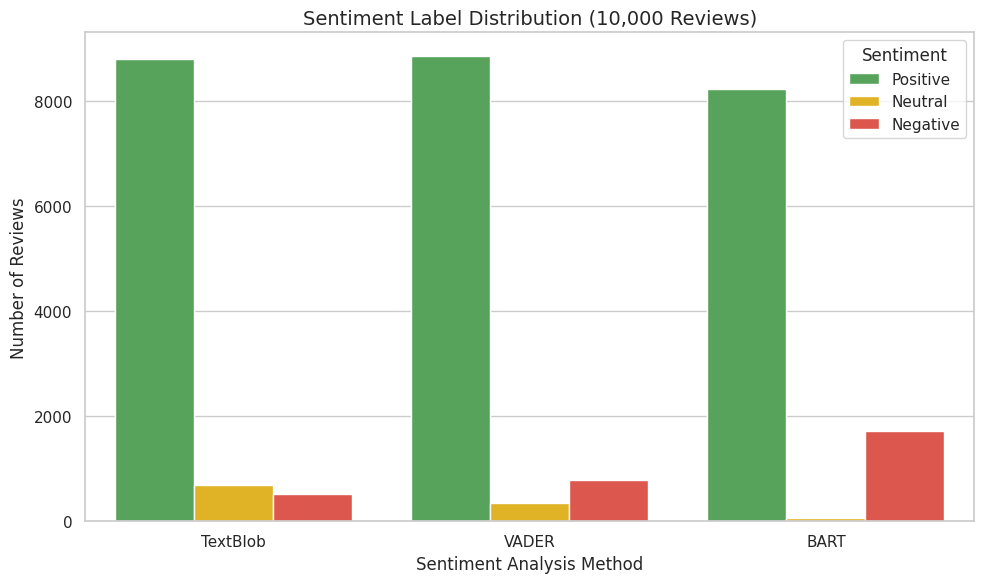

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style
sns.set(style="whitegrid")

# Define consistent color palette
palette = {
    "Positive": "#4CAF50",
    "Neutral": "#FFC107",
    "Negative": "#F44336"
}

# Create grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_melted,
    x="Method", y="Count", hue="Sentiment",
    palette=palette
)

# Customize the chart
plt.title("Sentiment Label Distribution (10,000 Reviews)", fontsize=14)
plt.xlabel("Sentiment Analysis Method")
plt.ylabel("Number of Reviews")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()
